In [1]:
import sys
sys.path += ['/home/lorenzo/Scrivania/My_projects/DeepWalk/P2Vec/Package/']  

from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

from p2vec import *
from p2vecNS import *
from est import *

import warnings
warnings.filterwarnings("ignore")


In [2]:
n = 10000
c_in = 10
c_out = 3
C = np.array([[c_in, c_out], [c_out, c_in]])
σv = np.ones(n)
σv[:int(n/2)] = -1
σv = np.reshape(σv, (n,1))
one = np.reshape(np.ones(n), (n,1))
Cm = (c_in + c_out)/2*one@one.T + (c_in - c_out)/2*σv@σv.T
A = np.random.binomial(1, Cm/(2*n))
A = np.sign(A + A.T)

from scipy import sparse

A = csr_matrix(A)
D_1 = diags((A@np.ones(n))**(-1))
P = D_1.dot(A)

In [3]:
Pv = [P]
dim = 128
n_epochs = 25
walk_length = 7
k = 20
η0 = 1.
ηfin = 10**(-6)
γ = 1.
symmetric = True
scheduler_type = 'linear'
recompute_labels = True
d = A@np.ones(n)
Λ = diags(d)/np.mean(d)

p2v = CreateEmbedding(Pv, Λ = Λ, dim = dim, n_epochs = n_epochs, walk_length = walk_length, k = k, η0 = η0, ηfin = ηfin, 
          γ = γ, symmetric = symmetric, scheduler_type = scheduler_type, recompute_labels = recompute_labels) 

Running the optimization for k = 1


KeyboardInterrupt: 

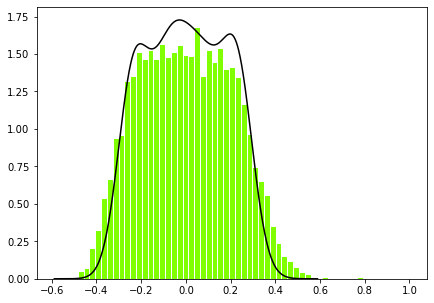

In [29]:
p2v.plotDistr(np.random.randint(n))

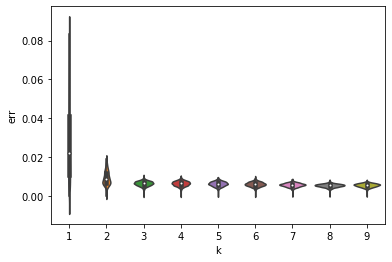

In [30]:
indeces = np.random.choice(np.arange(n), 1000)
kv = np.arange(1,10)

if symmetric == True:
    ta = TestApprox(p2v.Φ, indeces, kv)
else:
    ta = TestApprox(p2v.Φ, indeces, kv, Ψ = p2v.Ψ)
ta.PlotTest()

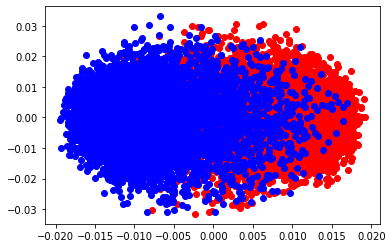

In [31]:
Φ = p2v.Φ
pca = PCA(n_components = 2)
pca.fit(Φ.T)
plt.scatter(pca.components_[0][σv[:,0] == 1], pca.components_[1][σv[:,0] == 1], color = 'r')
plt.scatter(pca.components_[0][σv[:,0] == -1], pca.components_[1][σv[:,0] == -1], color = 'b')
plt.show();

In [1]:
negative = 8
scheduler_type = 'linear'
η0 = 1.

p2vNS = CreateEmbeddingNS(Pv, Λ = Λ, dim = dim, n_epochs = n_epochs, walk_length = walk_length, negative = negative,
    η0 = η0, ηfin = ηfin, γ = γ, symmetric = symmetric, scheduler_type = scheduler_type) 

NameError: name 'CreateEmbeddingNS' is not defined

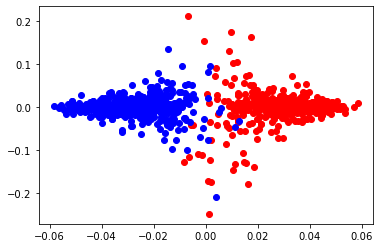

In [8]:
ΦNS = p2vNS.Φ

pcaNS = PCA(n_components = 2)
pcaNS.fit(ΦNS.T)
plt.scatter(pcaNS.components_[0][σv[:,0] == 1], pca.components_[1][σv[:,0] == 1], color = 'r')
plt.scatter(pcaNS.components_[0][σv[:,0] == -1], pca.components_[1][σv[:,0] == -1], color = 'b')
plt.show();

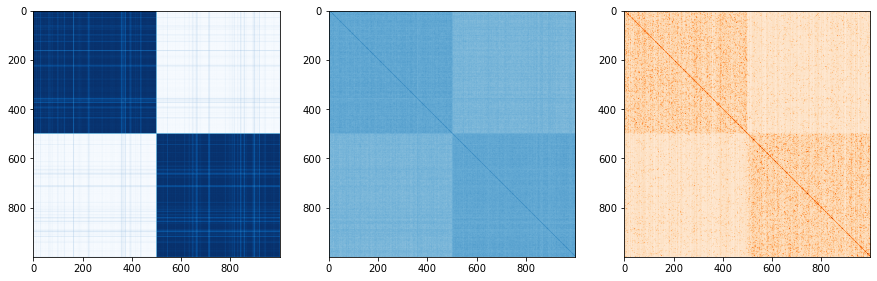

In [13]:
p = [P]
for t in range(1, walk_length):
    p.append(γ*P@p[-1])

p = np.sum(p, axis = 0)
p = p/np.mean(p@np.ones(n))


fig, ax = plt.subplots(1, 3, figsize = (15,5))

if symmetric:
    ax[0].imshow(Φ@Φ.T, cmap = 'Blues', vmin = -1, vmax = 1)
    ax[1].imshow(ΦNS@ΦNS.T, cmap = 'Blues', vmin = -1, vmax = 1)
else:
    Ψ = p2v.Ψ
    ΨNS = p2v.ΨNS
    ax[0].imshow(Φ@Φ.T)
    ax[1].imshow(ΦNS@ΦNS.T)
    
ax[2].imshow(p.A, cmap = 'Oranges', vmin = 0, vmax = 0.005)
plt.show();

In [18]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2, random_state=0).fit(Φ)
print("Overlap ours: " + str(2*np.abs(np.sum(2*kmeans.labels_ - 1 == σv[:,0])/n - 0.5)))

kmeans = KMeans(n_clusters = 2, random_state=0).fit(pca.components_.T)
print("Overlap ours + PCA: " + str(2*np.abs(np.sum(2*kmeans.labels_ - 1 == σv[:,0])/n - 0.5)))

print("-----------------------------------------------")

kmeans = KMeans(n_clusters = 2, random_state=0).fit(ΦNS)
print("Overlap NS: " + str(2*np.abs(np.sum(2*kmeans.labels_ - 1 == σv[:,0])/n - 0.5)))

kmeans = KMeans(n_clusters = 2, random_state=0).fit(pcaNS.components_.T)
print("Overlap NS + PCA: " + str(2*np.abs(np.sum(2*kmeans.labels_ - 1 == σv[:,0])/n - 0.5)))

Overlap ours: 0.992
Overlap ours + PCA: 0.992
-----------------------------------------------
Overlap NS: 0.966
Overlap NS + PCA: 0.966
